In [134]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.cell_roi import RandomROISample
from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_DAT import AutoDAT
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader

###########################################
# Make a series of 1-frame measure windows from PhotoZ into a movie
# Asks user to annotate DIC/Fluorescence images for electrode + layer and barrel boundaries
#       Puts this metadata into ROI .dat files
# Uses DIC-to-ZDA frame mapping (rotation and scaling) to annotate the PhotoZ frames
# Uses autoPhotoZ to take frame images for move
#  - 8/24/23: 
#        Support any number of barrels.
#        add ROI generation: layer/barrel ROIs
###########################################

In [120]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/"
camera_program = 4

# annotation settings
skip_draw_annotations = True  # If True, don't draw any new annotations

# Movie maker settings
enable_photoZ_interact = False
initialize_photoZ = True

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()

In [4]:
stim_df = {
    'Date': [],
    "Slice_Loc": [],
    'stim_distance1': [], # distance to L4-L5 boundary
    'stim_distance2': [] # distance to neighboring barrel (in final CSV, this is 0 if home barrel)
}
already_drawn_slic_loc = {}

In [5]:
# First ask user to annotate some images with:
#       - Electrode loc 
#       - L4 - L5 boundary
#       - Barrel boundary that is being crossed
# Calculate:
#       - Distance from electrode to L4 boundary (distance1)
#       - Distance from electrode to neighboring barrel (distance2)
# This will be used to calculate distance from electrode to L4 boundary and from electrode to neighboring barrel

def parse_date(subdir):
    try:
        char_select = -len('dd-mm-yyyy')
        date = subdir.split("/")[-1][char_select:]
        date = [int(x) for x in date.split("-")]
        date = "/".join([str(d) for d in date])
        return date
    except Exception as e:
        print(e, "could not process date.")
        return subdir

data_map = {}
for subdir, dirs, files in os.walk(data_dir):

    if 'notUsable' in subdir:
        continue
    if 'hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"
        
        # optionally process date
        date = parse_date(subdir)

        # take selected zda and expand into separate subdir for each zda file
        print(os.listdir(selected_zda_dir))
        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                print("\n", selected_zda_dir + "/" + zda_file)
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]

                if subdir not in data_map:
                    data_map[subdir] = {}
                if slic_id not in data_map[subdir]:
                    data_map[subdir][slic_id] = {}
                if loc_id not in data_map[subdir][slic_id]:
                    data_map[subdir][slic_id][loc_id] = {
                        'zda_files': []
                    }
                data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)

                annotate_id = date + "_" + str(slic_id) + "_" + str(loc_id)
                if skip_draw_annotations:
                    continue
                if annotate_id in already_drawn_slic_loc:
                    print("Already annotated ", annotate_id, ", skipping.")
                    continue
                already_drawn_slic_loc[annotate_id] = True

                # read in 8-bit single TIF images to array, apply same cropping/binning
                image_data = {}
                cam_settings = CameraSettings().get_program_settings(camera_program)
                binning = int(2048 / 400) # if want size similar to RLI
                TIFLoader(dic_dir, 
                          cam_settings, 
                          binning, 
                          crop=False, 
                          flip_horiz=True).load_files(image_data, 
                                                      slice_target=slic_id)

                img_aligner = ImageAlign()

                for slic in image_data:
                    for loc in image_data[slic]:
                        if slic != slic_id or loc != loc_id:
                            continue
                        print(slic, loc)

                        # DICs
                        fluor = None
                        if 'f' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['f']
                        elif 'fe' in image_data[slic][loc]:
                            fluor = image_data[slic][loc]['fe']
                        # img = image_data[slic][loc]['i']

                        dic_electrode = None
                        if 'e' in image_data[slic][loc]:
                            dic_electrode = image_data[slic][loc]['e']
                        else:
                            dic_electrode = fluor

                        dic_electrode = np.array(dic_electrode, dtype=np.uint8)
                        orig_arr_shape = dic_electrode.shape

                        # ask user to select site of stim and layer/barrel borders
                        #       - Distance from electrode to L4 boundary (distance1)
                        #       - Distance from electrode to neighboring barrel (distance2)
                        if not skip_draw_annotations:
                            window_title = date + " " + rec_id

                            # ask user to select electrode
                            dic_electrode, electrode_coords = img_aligner.draw_electrode_on_image(
                                dic_electrode, 
                                window_title + " Electrode")
                            dic_electrode = np.array(dic_electrode)

                            # mark the electrode location into fluor image
                            x_el, y_el = electrode_coords['electrode']
                            for dx in range(-5, 5):
                                for dy in range(-5, 5):
                                    if x_el + dx >= 0 and x_el + dx < fluor.shape[1] and y_el + dy >= 0 and y_el + dy < fluor.shape[0]:
                                        fluor[int(y_el) + dy, int(x_el) + dx] = 0

                            # ask user to select L4 - L5 boundary
                            distance1_boundary, distance1_coords = img_aligner.draw_electrode_on_image(
                                fluor,
                                window_title + " Distance1 Boundary (L4 - L5 boundary)")
                            distance1_boundary = np.array(distance1_boundary)

                            # ask user to select barrel boundary
                            distance2_boundary, distance2_coords = img_aligner.draw_electrode_on_image(
                                fluor,
                                window_title + " Distance2 Boundary (Barrel boundary)")
                            distance2_boundary = np.array(distance2_boundary)
                            
                            # make 1 row of 2 subplots
                            fig, axes = plt.subplots(1, 3)
                            axes[0].imshow(dic_electrode, cmap='gray')
                            axes[1].imshow(fluor, cmap='gray')
                            
                            x_d1, y_d1 = distance1_coords['electrode']
                            x_d2, y_d2 = distance2_coords['electrode']

                            for ax in axes[:2]:
                                l1, = ax.plot(x_el, y_el, marker="*", color='red', label="Electrode")
                                l2, = ax.plot(x_d1, y_d1, marker="*", color='green', label="L4 - L5 boundary")
                                l3, = ax.plot(x_d2, y_d2, marker="*", color='blue', label="Barrel boundary")
                                ax.set_yticks([])
                                ax.set_xticks([])


                            axes[2].legend(handles=[l1, l2, l3],
                                           labels=["Electrode", "L4 - L5 boundary", "Barrel boundary"])
                            axes[2].axis('off')
                            plt.show()

                            # no need to transform the coordinates, just calculate distances and convert px -> microns
                            dic_um_per_px = 425 / fluor.shape[1]
                            distance1 = Line([x_el, y_el], [x_d1, y_d1]).get_length() * dic_um_per_px
                            distance2 = Line([x_el, y_el], [x_d2, y_d2]).get_length() * dic_um_per_px
                            print("Distance1 (L4 - L5 boundary):", distance1)
                            print("Distance2 (Barrel boundary):", distance2)

                            # append data to Dataframe to write to CSV
                            stim_df["Date"].append(date)
                            stim_df["Slice_Loc"].append(str(slic) + "_" + str(loc))
                            stim_df["stim_distance1"].append(distance1)
                            stim_df["stim_distance2"].append(distance2)
                            
                            
stim_df = pd.DataFrame(stim_df)
stim_df



 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24
['02_01_01.zda', '02_02_01.zda', '02_03_01.zda', '04_01_01.zda', '04_02_01.zda', '04_02_02.zda', '05_01_01.zda', '05_01_02.zda', '05_02_01.zda', '2_1_barrel_boundary.dat', '2_1_electrode.dat', '2_2_barrel_boundary.dat', '2_2_electrode.dat', '2_3_barrel_boundary.dat', '2_3_electrode.dat', '2_barrel_rois.dat', '2_barrel_roisROIs-rand_0.dat', '2_barrel_roisROIs-rand_1.dat', '4_1_barrel_boundary.dat', '4_1_electrode.dat', '4_2_barrel_boundary.dat', '4_2_electrode.dat', '4_barrel_rois.dat', '4_barrel_roisROIs-rand_0.dat', '4_barrel_roisROIs-rand_1.dat', '5_1_barrel_boundary.dat', '5_1_electrode.dat', '5_2_barrel_boundary.dat', '5_2_electrode.dat', '5_barrel_rois.dat', '5_barrel_roisROIs-rand_0.dat', '5_barrel_roisROIs-rand_1.dat']

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//02_01_01.zda

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda

,Date,Slice_Loc,stim_distance1,stim_distance2


In [6]:
if skip_draw_annotations:
    # load from CSV
    stim_df = pd.read_csv(data_dir + "sagittal_crossing_with_distances.csv")
else:
    # write df to CSV
    stim_df.to_csv(data_dir + "sagittal_crossing_with_distances.csv", index=False)

In [7]:
# go through the ZDA files and extract amp arrays 
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id):
    return subdir + "/" + "ampArray_" + slic_loc_id + ".dat"

for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    aPhz = AutoPhotoZ(data_dir=subdir)
    if enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                print(zda_file)
                amp_array_filename = get_amp_array_filename(subdir, slic_loc_id)
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)
                    aPhz.save_background(filename=amp_array_filename)

                if 'amp_arrays' not in data_map[subdir][slic_id][loc_id]:
                    data_map[subdir][slic_id][loc_id]['amp_arrays'] = []
                    data_map[subdir][slic_id][loc_id]['roi_file'] = selected_zda_dir + str(slic_id) + "_barrel_rois.dat"

                data_map[subdir][slic_id][loc_id]['amp_arrays'].append(amp_array_filename)
                data_map[subdir][slic_id][loc_id]['roi_file'] = selected_zda_dir + str(slic_id) + "_barrel_rois.dat"
                        

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//02_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//02_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//02_03_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//04_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//04_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//04_02_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//05_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//05_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//05_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//01_01_01.zda


In [8]:
# use read_dat_arr_file to read in the amp arrays
# also read in the barrel ROIs (#_barrel_rois.dat) to know which pixels' amplitudes to analyze
def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

final_df = {
    "Date": [],
    "Slice_Loc": [],
    "Most_Caudal_Barrel": [],
    "Stim_Location": [],
    "Home_Barrel": [],
    "Home_Barrel_Amp": [],
    "Neighbor_Barrel_Amp": [],
    "Neighbor_Responding_Area_Fraction": [],
    'stim_distance1': [],
    'stim_distance2': [],
    'crossing_direction': [] # to caudal or to rostral
}

# load catalog of metadata
catalog_df = pd.read_csv(data_dir + "sagittal_catalog.csv")
show_plots = False

for subdir in data_map:
    date = parse_date(subdir)
    
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file']
            roi_list = rfr = ROIFileReader(roi_file).get_roi_list()  # list of ROIs as diode numbers

            for amp_arr_file in data_map[subdir][slic_id][loc_id]['amp_arrays']:
                print(amp_arr_file)

                amp_array = read_dat_arr_file(amp_arr_file)


                # get amp cutoff for this slice/loc from catalog_df
                slice_loc_id = str(slic_id) + "_" + str(loc_id)

                # convert mm/dd/yy to mm/dd/yyyy
                if len(date.split("/")[-1]) < len("yyyy"):
                    date = date.split("/")
                    date = date[0] + "/" + date[1] + "/20" + date[2]
                print(date, slice_loc_id)

                masked_amp_array = np.zeros(amp_array.shape)

                # convert diode to xy
                rois = [LaminarROI(roi).get_points() for roi in roi_list]

                slice_loc_df = catalog_df[(catalog_df['Slice_Loc'] == slice_loc_id) & 
                                          (catalog_df['Date'] == date)]

                # get home barrel index (1-indexed)
                home_barrel = slice_loc_df['Home_Barrel'].values[0]

                # get neighboring barrel index (1-indexed)
                neighbor_barrel = 3 - home_barrel

                # get average amplitude of home barrel
                home_barrel_roi = rois[home_barrel - 1]
                home_barrel_amp = np.mean([amp_array[y, x] for x, y in home_barrel_roi])

                # get average amplitude of neighboring barrel
                neighbor_barrel_roi = rois[neighbor_barrel - 1]
                neighbor_barrel_amp = np.mean([amp_array[y, x] for x, y in neighbor_barrel_roi])

                amp_cutoff = home_barrel_amp * 0.5

                # mask out everything except the ROIs
                for roi in rois:
                    for x, y in roi:
                        if amp_array[y, x] > amp_cutoff:
                            masked_amp_array[y, x] = amp_array[y, x]
                
                # display amp array
                if show_plots:
                    plt.imshow(masked_amp_array, cmap='hot')
                    plt.title(date + " " + slice_loc_id + " Amp cutoff: " + str(amp_cutoff)[:4])
                    plt.show()

                # calculate barrel ROI responding area fraction of neighbor barrel
                resp_area = 0
                for x, y in neighbor_barrel_roi:
                    if masked_amp_array[y, x] > amp_cutoff:
                        resp_area += 1
                resp_area = resp_area / len(neighbor_barrel_roi)

                # calculate crossing direction
                most_caudal_barrel = slice_loc_df['Most_Caudal_Barrel'].values[0]
                if home_barrel == most_caudal_barrel:
                    crossing_direction = "Rostral"
                else:
                    crossing_direction = "Caudal"

                
                # get stim distances from stim_df
                slice_loc_stim_df = stim_df[(stim_df['Date'] == date) &
                                            (stim_df['Slice_Loc'] == slice_loc_id)]

                # append to final_df
                final_df["Date"].append(date)
                final_df["Slice_Loc"].append(slice_loc_id)
                final_df["Most_Caudal_Barrel"].append(most_caudal_barrel)
                final_df["Stim_Location"].append(slice_loc_df['Stim_Location'].values[0])
                final_df["Home_Barrel"].append(home_barrel)
                final_df["Home_Barrel_Amp"].append(home_barrel_amp)
                final_df["Neighbor_Barrel_Amp"].append(neighbor_barrel_amp)
                final_df["Neighbor_Responding_Area_Fraction"].append(resp_area)
                final_df['stim_distance1'].append(slice_loc_stim_df['stim_distance1'].values[0])
                final_df['stim_distance2'].append(slice_loc_stim_df['stim_distance2'].values[0])
                final_df['crossing_direction'].append(crossing_direction)

# create final_df Dataframe
final_df = pd.DataFrame(final_df)
final_df

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/ampArray_2_1.dat
5/29/2024 2_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/ampArray_2_2.dat
5/29/2024 2_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/ampArray_2_3.dat
5/29/2024 2_3
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/ampArray_4_1.dat
5/29/2024 4_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/ampArray_4_2.dat
5/29/2024 4_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/ampArray_4_2.dat
5/29/2024 4_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/ampArray_5_1.dat
5/29/2024 5_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/ampArray_5_1.dat
5/29/2024 5_1
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/ampArray_5_2.dat
5/29/2024 5_2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/

,Date,Slice_Loc,Most_Caudal_Barrel,Stim_Location,Home_Barrel,Home_Barrel_Amp,Neighbor_Barrel_Amp,Neighbor_Responding_Area_Fraction,stim_distance1,stim_distance2,crossing_direction
0,5/29/2024,2_1,1,L4,2,4.525552,1.739531,0.176933,60.813524,82.793827,Caudal
1,5/29/2024,2_2,1,L2/3,2,0.823354,0.501213,0.821756,121.039039,52.296078,Caudal
2,5/29/2024,2_3,1,L2/3,1,1.003008,0.287005,0.018215,121.041936,145.522129,Rostral
3,5/29/2024,4_1,2,L2/3,2,0.959258,0.320275,0.058433,120.001227,78.297929,Rostral
4,5/29/2024,4_2,2,L2/3,1,0.676220,0.500211,0.962894,154.832646,103.624931,Caudal
5,5/29/2024,4_2,2,L2/3,1,0.676220,0.500211,0.962894,154.832646,103.624931,Caudal
6,5/29/2024,5_1,1,L2/3,1,0.723893,0.599517,0.989717,191.644902,108.093227,Rostral
7,5/29/2024,5_1,1,L2/3,1,0.723893,0.599517,0.989717,191.644902,108.093227,Rostral
8,5/29/2024,5_2,1,L2/3,2,1.015209,0.467118,0.363429,166.888653,73.996707,Caudal
9,5/31/2024,1_1,2,L2/3,2,6.928083,3.090578,0.265723,112.271697,144.845388,Rostral


In [9]:
# save to CSV
final_df.to_csv(data_dir + "sagittal_crossing_final.csv", index=False)

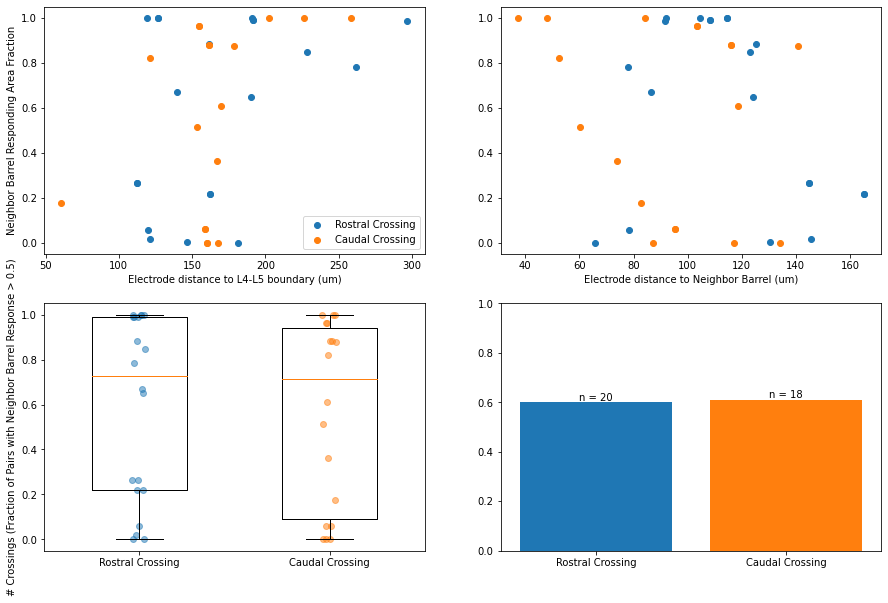

In [10]:
# plot distributions of responding area fraction for each crossing direction as scatter plots

# scatter plot of responding area fraction vs distance to L4-L5 boundary
# and vs distance to barrel boundary
handles = []
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for direction in ["Rostral", "Caudal"]:
    df = final_df[final_df['crossing_direction'] == direction]
    l1 = ax[0][0].scatter(df['stim_distance1'], df['Neighbor_Responding_Area_Fraction'], label=direction + " Crossing")
    l2 = ax[0][1].scatter(df['stim_distance2'], df['Neighbor_Responding_Area_Fraction'], label=direction + " Crossing")
    handles .append(l1)

ax[0][0].set_ylabel("Neighbor Barrel Responding Area Fraction")
ax[0][0].set_xlabel("Electrode distance to L4-L5 boundary (um)")
ax[0][1].set_xlabel("Electrode distance to Neighbor Barrel (um)")
ax[0][0].legend(handles, ["Rostral Crossing", "Caudal Crossing"])

# in ax[1][0], plot responding area fraction distribution for each crossing direction
for i, direction in enumerate(["Rostral", "Caudal"]):
    df = final_df[final_df['crossing_direction'] == direction]
    x_jitter = [i + random.uniform(-0.04, 0.04) for _ in range(len(df))]
    l1 = ax[1][0].scatter(x_jitter, df['Neighbor_Responding_Area_Fraction'], alpha=0.5)
    
    

    # insert box and whisker plot for each crossing direction in ax[1][0]
    ax[1][0].boxplot([df['Neighbor_Responding_Area_Fraction']], positions=[i], widths=0.5)

    # in ax[1][1], plot # crossings (responding area > 0.5) as bar graph for each crossing direction
    n_crossings = len(df[df['Neighbor_Responding_Area_Fraction'] > 0.5]) / len(df)
    ax[1][1].bar(i, n_crossings)
    ax[1][1].set_xticks([0, 1])
    ax[1][1].set_xlim(-0.5, 1.5)
    ax[1][1].set_ylim(0, 1)
    # annotate bar graph with number of pairs observed
    ax[1][1].text(i, n_crossings, "n = " + str(len(df)), ha='center', va='bottom')

ax[1][0].set_xticks([0, 1])
ax[1][0].set_xlim(-0.5, 1.5)
ax[1][1].set_xticklabels(["Rostral Crossing", "Caudal Crossing"])
ax[1][0].set_xticklabels(["Rostral Crossing", "Caudal Crossing"])
ax[1][0].set_ylabel("Neighbor Barrel Responding Area Fraction")
ax[1][0].set_ylabel("# Crossings (Fraction of Pairs with Neighbor Barrel Response > 0.5)")



plt.show()

In [11]:
# now generate random barrel samples to extract latency
# create random ROI samples of 1 pixel
# Generate ROI files of specified sizes

def get_rand_roi_filename(subdir, barrel_idx, file):
    return subdir + '/' + file.split('.dat')[0] +'ROIs-rand_' + str(barrel_idx) + '.dat'

roi_sampler = RandomROISample(1)
data_file_map = {}
distance_map = {}
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if '_barrel_rois.dat' in file:

            # load barrel file (lists of lists of diode numbers)
            barrel_rois = ROIFileReader(subdir + '/' + file).get_roi_list()

            # convert from diode to pixel
            barrel_rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in barrel_rois]
            
            # map pixel to ROI number
            barrel_roi_map = {}
            for i in range(len(barrel_rois)):
                for px in barrel_rois[i]:
                    px_string = str(px[0]) + ',' + str(px[1])
                    barrel_roi_map[px_string] = i

            # take sample of 100 random pixels from barrel ROIs
            new_rois = {i: [] for i in range(len(barrel_rois))}
            nr_map = {}
            while(any([len(new_rois[k]) < 100 for k in new_rois])):
                i, j = roi_sampler.get_random_point()
                px_string = str(j) + ',' + str(i)
                if px_string not in barrel_roi_map \
                    or (j,i) in nr_map:
                    continue
                else:
                    barrel_idx = barrel_roi_map[px_string]
                    if len(new_rois[barrel_idx]) < 100:
                        new_rois[barrel_idx].append([j, i])
                    nr_map[(j, i)] = 1
                occupancy = [len(new_rois[k]) for k in new_rois]
            print(len(new_rois))

            # convert pixels to diode numbers
            roi_cr = ROICreator(None)
            for k in new_rois:
                new_rois[k] = [[roi_cr.convert_point_to_diode_number(px)] for px in new_rois[k]]

            # write each new ROI to a separate file
            rfw = ROIFileWriter()
            selected_zda_dir = subdir 
            subdir_shortened = subdir.split('\\selected_zda')[0]
            if subdir_shortened not in data_file_map:
                data_file_map[subdir_shortened] = {}
            data_file_map[subdir_shortened][file] = []
            for barrel_idx in new_rois:
                rand_roi_file = get_rand_roi_filename(selected_zda_dir, barrel_idx, file)
                rfw.write_regions_to_dat(rand_roi_file, new_rois[barrel_idx])
                data_file_map[subdir_shortened][file].append(rand_roi_file)

2
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24\selected_zda/2_barrel_roisROIs-rand_0.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24\selected_zda/2_barrel_roisROIs-rand_1.dat
2
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24\selected_zda/4_barrel_roisROIs-rand_0.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24\selected_zda/4_barrel_roisROIs-rand_1.dat
2
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24\selected_zda/5_barrel_roisROIs-rand_0.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24\selected_zda/5_barrel_roisROIs-rand_1.dat
2
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24\selected_zda/1_barrel_roisROIs-rand_0.dat
Regions written to: C:/Users/jjudge3/Desktop/Da

In [12]:
# now load these ROI files into PhotoZ and extract latency and halfwidth dat files
# go through the ZDA files and extract amp arrays 
if enable_photoZ_interact:
    pa.alert("Set measure window width to > 70 for half-width measurement.")
for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    if enable_photoZ_interact:
        aPhz = AutoPhotoZ(data_dir=subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file'].split("/")[-1]
            roi_barrel_files = data_file_map[subdir][roi_file]

            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                print(zda_file)
                if not os.path.exists(zda_file):
                    print("ZDA file does not exist, skipping.")
                    continue
                
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)

                for i_barrel, barrel_roi_file in enumerate(roi_barrel_files):

                    if enable_photoZ_interact:
                        aPhz.select_roi_tab()
                        aPhz.open_roi_file(barrel_roi_file)
                        print("Opened ROI file", barrel_roi_file)
                        
                    # save half-width values from PhotoZ
                    hw_filename = subdir + "/" + "hw_" + slic_loc_id + "_barrel" + str(i_barrel+1) + ".dat" 
                    if enable_photoZ_interact:
                        aPhz.select_half_width_trace_value()
                        aPhz.save_trace_values(hw_filename)

                    # save amp values from PhotoZ
                    amp_filename = subdir + "/" + "amp_" + slic_loc_id + "_barrel" + str(i_barrel+1) + ".dat" 
                    if enable_photoZ_interact:
                        aPhz.select_maxamp_trace_value()
                        aPhz.save_trace_values(amp_filename)
                        
                    # save latency values from PhotoZ
                    lat_filename = subdir + "/" + "lat_" + slic_loc_id + "_barrel" + str(i_barrel+1) + ".dat" 
                    if enable_photoZ_interact:
                        aPhz.select_latency_trace_value()
                        aPhz.save_trace_values(lat_filename)


                    if i_barrel+1 not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][i_barrel+1] = {}
                    data_map[subdir][slic_id][loc_id][i_barrel+1] = {'amp': amp_filename,
                                                                       'hw': hw_filename,
                                                                       'lat': lat_filename}

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//02_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//02_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//02_03_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//04_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//04_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//04_02_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//05_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//05_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-29-24/selected_zda//05_02_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal/05-31-24/selected_zda//01_01_01.zda


In [128]:
# load in the randomly sampled rois and calculate distance from ROI to electrode

def get_stim_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_electrode.dat"

def get_barrel_boundary_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_barrel_boundary.dat"

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['ROI',  'Value'])
    return data_arr

amp_dfs = []
for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    date = parse_date(subdir)
    if enable_photoZ_interact:
        aPhz = AutoPhotoZ(data_dir=subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            # we also need stim point for this slice/loc
            stim_file = get_stim_filename(selected_zda_dir, slic_id, loc_id)
            stim_point = ROIFileReader(stim_file).get_roi_list()
            stim_point = LaminarROI(stim_point[0], input_diode_numbers=True).get_points()[0]

            # and get barrel boundary location
            barrel_boundary_file = get_barrel_boundary_filename(selected_zda_dir, slic_id, loc_id)
            barrel_boundary = ROIFileReader(barrel_boundary_file).get_roi_list()
            barrel_boundary = LaminarROI(barrel_boundary[0], input_diode_numbers=True).get_points()[0]

            # axis of barrel boundary to electrode
            barrel_axis = Line(stim_point, barrel_boundary)

            roi_file = data_map[subdir][slic_id][loc_id]['roi_file'].split("/")[-1]
            roi_barrel_files = data_file_map[subdir][roi_file]

            for i_barrel, barrel_roi_file in enumerate(roi_barrel_files):
                roi_list = ROIFileReader(barrel_roi_file).get_roi_list()
                # convert from diode to pixel
                roi_list = [LaminarROI(roi, input_diode_numbers=True).get_points()
                            for roi in roi_list]
                
                # for each ROI, calculate distance to electrode
                # all ROIs are single-pixel
                distances = [Line(stim_point, roi[0]).get_length() for roi in roi_list]

                # also calculate the distance from the barrel boundary along the electrode-barrel line
                distances_along_axis = [barrel_axis.get_displacement_along_segment(barrel_boundary, roi[0]) 
                                        for roi in roi_list]

                # load the amp, hw, and lat files for this barrel
                amp_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['amp']
                hw_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['hw']
                lat_file = data_map[subdir][slic_id][loc_id][i_barrel+1]['lat']

                try:
                    amp = read_dat_trace_file(amp_file)
                    hw = read_dat_trace_file(hw_file)
                    lat = read_dat_trace_file(lat_file)
                except Exception as e:
                    print(e)
                    continue

                # get crossing direction, stim location, and electrode distances from final_df
                # convert mm/dd/yy to mm/dd/yyyy
                
                if len(date.split("/")[-1]) < len("yyyy"):
                    date = date.split("/")
                    date = date[0] + "/" + date[1] + "/20" + date[2]
                slice_loc_df = final_df[(final_df['Date'] == date) &
                                        (final_df['Slice_Loc'] == slic_loc_id)]
                crossing_direction = slice_loc_df['crossing_direction'].values[0]
                stim_location = slice_loc_df['Stim_Location'].values[0]
                stim_distance1 = slice_loc_df['stim_distance1'].values[0]
                stim_distance2 = slice_loc_df['stim_distance2'].values[0]
                home_barrel = slice_loc_df['Home_Barrel'].values[0]

                amp = amp.join(hw, rsuffix='_hw')
                amp = amp.join(lat, rsuffix='_lat')
                amp.insert(4, 'Distance', distances)
                amp.insert(4, 'Distance_Along_Barrel_Axis', distances_along_axis)
                amp.insert(5, 'Barrel', [i_barrel+1 for _ in range(len(amp['ROI']))])
                amp.insert(6, 'Crossing_Direction', [crossing_direction for _ in range(len(amp['ROI']))])
                amp.insert(7, 'Stim_Location', [stim_location for _ in range(len(amp['ROI']))])
                amp.insert(8, 'Stim_Distance1', [stim_distance1 for _ in range(len(amp['ROI']))])
                amp.insert(9, 'Stim_Distance2', [stim_distance2 for _ in range(len(amp['ROI']))])
                amp.insert(10, 'Date', [date for _ in range(len(amp['ROI']))])
                amp.insert(11, 'Slice_Loc', [slic_loc_id for _ in range(len(amp['ROI']))])
                amp.insert(12, 'Home_Barrel', [home_barrel for _ in range(len(amp['ROI']))])
                amp.insert(13, 'Slice', [slic_id for _ in range(len(amp['ROI']))])
                amp.insert(14, 'Loc', [loc_id for _ in range(len(amp['ROI']))])
                amp.insert(15, 'Is_Home_Barrel', [1 if i_barrel+1 == home_barrel else 0 for _ in range(len(amp['ROI']))])
                amp.insert(16, "Is_Rostral_Crossing", [1 if crossing_direction == "Rostral" else 0 for _ in range(len(amp['ROI']))])
                amp.insert(17, "Animal", [date for _ in range(len(amp['ROI']))])
                amp.insert(18, "Litter", [1 if date in ['6/4/2024', '6/3/2024'] else 0 for _ in range(len(amp['ROI']))])

                amp = amp[pd.to_numeric(amp.Value, errors='coerce').notnull()]
                amp['Value'] /= 1000
                amp_dfs.append(amp)
        
pixel_df = pd.concat(amp_dfs)
pixel_df = pixel_df[['Date', 'Slice_Loc', 'ROI', 'Value', 'Value_hw', 
                                 'Value_lat', 'Distance', 'Distance_Along_Barrel_Axis', 'Barrel', 'Home_Barrel',
                                    'Crossing_Direction', 'Stim_Location', 'Stim_Distance1', 'Stim_Distance2',
                                    'Slice', 'Loc', 'Is_Home_Barrel', 'Is_Rostral_Crossing', 'Animal', 'Litter'
                                 ]]

pixel_df

,Date,Slice_Loc,ROI,Value,Value_hw,Value_lat,Distance,Distance_Along_Barrel_Axis,Barrel,Home_Barrel,Crossing_Direction,Stim_Location,Stim_Distance1,Stim_Distance2,Slice,Loc,Is_Home_Barrel,Is_Rostral_Crossing,Animal,Litter
0,5/29/2024,2_1,1,0.001650,17.9312,47.7256,24.083189,15.811388,1,2,Caudal,L4,60.813524,82.793827,2,1,0,0,5/29/2024,0
1,5/29/2024,2_1,2,0.002271,11.0478,49.4693,29.427878,22.768399,1,2,Caudal,L4,60.813524,82.793827,2,1,0,0,5/29/2024,0
2,5/29/2024,2_1,3,0.001663,35.4531,51.8820,17.262677,8.854377,1,2,Caudal,L4,60.813524,82.793827,2,1,0,0,5/29/2024,0
3,5/29/2024,2_1,4,0.001419,18.2266,50.9663,26.476405,16.760072,1,2,Caudal,L4,60.813524,82.793827,2,1,0,0,5/29/2024,0
4,5/29/2024,2_1,5,0.000421,18.0327,51.4999,43.566042,36.682421,1,2,Caudal,L4,60.813524,82.793827,2,1,0,0,5/29/2024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6/4/2024,4_2,96,0.002119,13.6937,52.9408,43.046487,19.521720,2,1,Rostral,L2/3,181.137714,65.721297,4,2,0,1,6/4/2024,1
96,6/4/2024,4_2,97,0.001905,14.7922,52.7403,41.012193,19.834068,2,1,Rostral,L2/3,181.137714,65.721297,4,2,0,1,6/4/2024,1
97,6/4/2024,4_2,98,0.002414,11.5236,52.1650,41.012193,18.584678,2,1,Rostral,L2/3,181.137714,65.721297,4,2,0,1,6/4/2024,1
98,6/4/2024,4_2,99,0.000953,14.2703,54.8729,36.674242,22.957543,2,1,Rostral,L2/3,181.137714,65.721297,4,2,0,1,6/4/2024,1


In [129]:
pixel_df.to_csv(data_dir + "sagittal_crossing_final_by_pixel.csv", index=False)

p_val for latency home vs neighbor: 4.091202675555817e-200
p_val for half-width home vs neighbor: 1.3590725841109556e-70
p_val for amp home vs neighbor: 6.486426572005382e-87
p_val for latency home vs neighbor: 3.415656571351364e-117
p_val for half-width home vs neighbor: 1.010095059973506e-64
p_val for amp home vs neighbor: 3.7647035459215494e-82


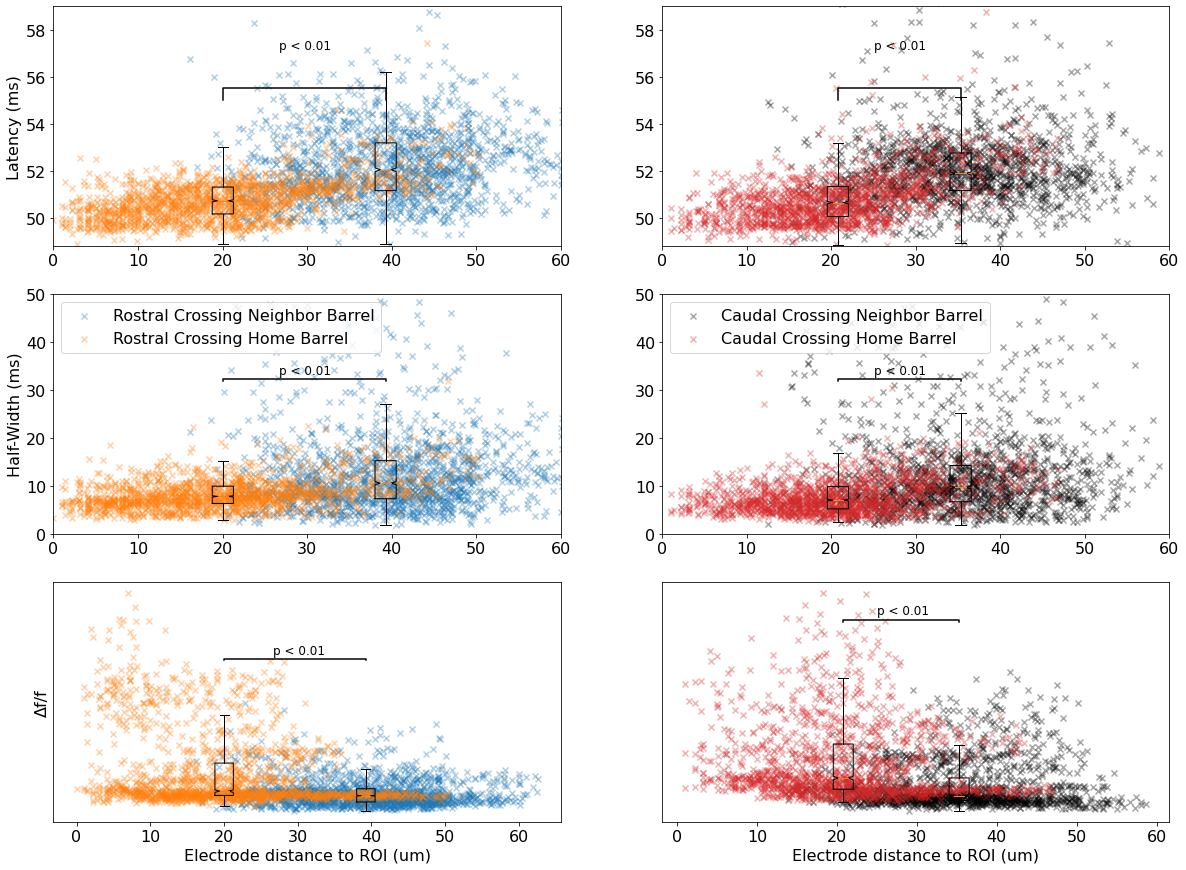

p_val for latency home vs neighbor: 4.091202675555817e-200
p_val for half-width home vs neighbor: 1.3590725841109556e-70
p_val for amp home vs neighbor: 6.486426572005382e-87
p_val for latency home vs neighbor: 3.415656571351364e-117
p_val for half-width home vs neighbor: 1.010095059973506e-64
p_val for amp home vs neighbor: 3.7647035459215494e-82


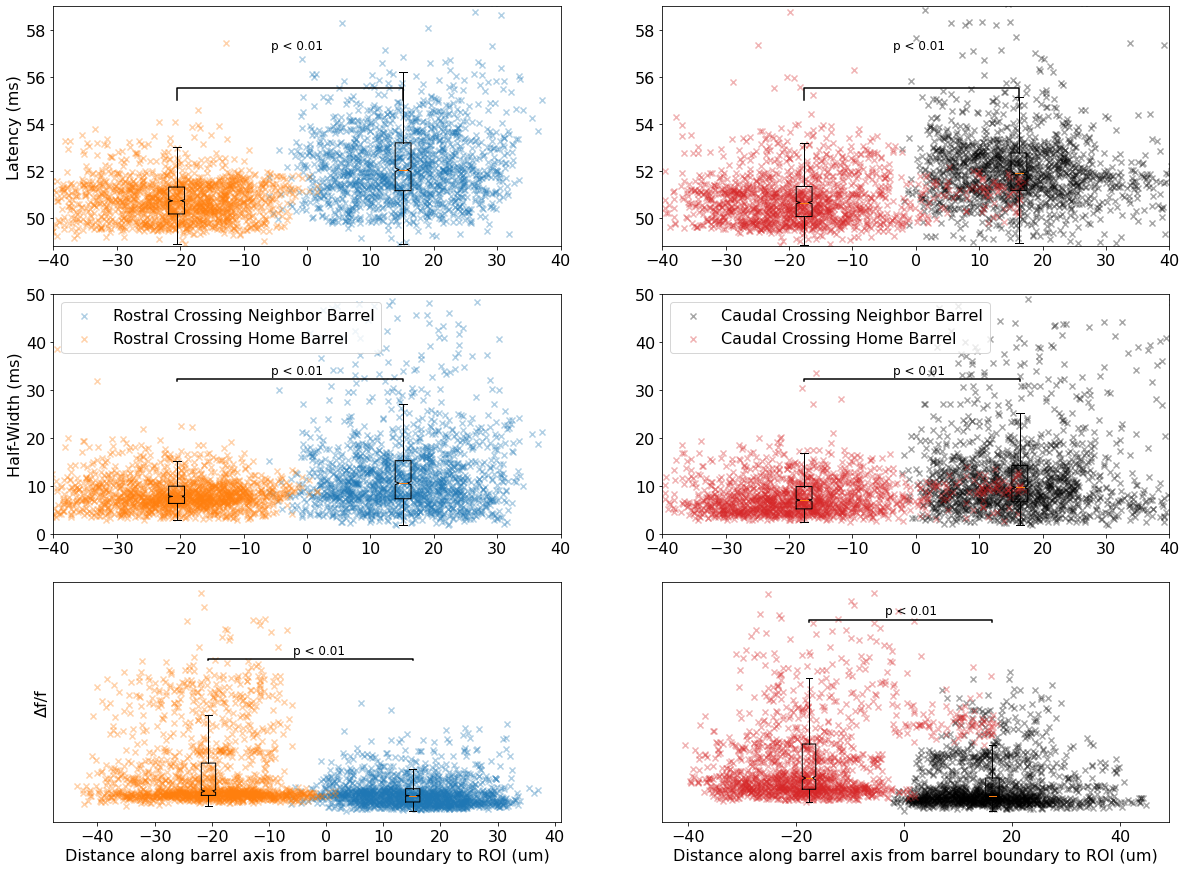

In [144]:
# plot latency vs electrode distance for each crossing direction
# optional amp cutoff
amp_cutoff = None
if amp_cutoff is not None:
    pixel_df = pixel_df[pixel_df['Value'] > amp_cutoff]
plt.rcParams.update({'font.size': 16})
for dist_type in ["Distance", "Distance_Along_Barrel_Axis"]:
    handles = []
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    colors = ['tab:blue', 'black', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    for i, direction in enumerate(["Rostral", "Caudal"]):
        df = pixel_df[pixel_df['Crossing_Direction'] == direction]
        
        # split this out by whether Barrel == Home_Barrel or not
        home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
        neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

        lat_home = home_barrel_df[(home_barrel_df['Value_lat'] < 1000) & (home_barrel_df['Value_lat'] > 48.8)]
        hw_home = home_barrel_df[(home_barrel_df['Value_hw'] < 1000) & (home_barrel_df['Value_hw'] > 0)]
        lat_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_lat'] < 1000) & (neighbor_barrel_df['Value_lat'] > 48.8)]
        hw_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_hw'] < 1000) & (neighbor_barrel_df['Value_hw'] > 0)]
        amp_home = home_barrel_df[(home_barrel_df['Value'] < 1000) & (home_barrel_df['Value'] > 0)]
        amp_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value'] < 1000) & (neighbor_barrel_df['Value'] > 0)]

        alph = 0.35
        l1 = ax[0][i].scatter(lat_neighbor[dist_type], lat_neighbor['Value_lat'], 
                            label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[i], marker='x')
        l2 = ax[1][i].scatter(hw_neighbor[dist_type], hw_neighbor['Value_hw'],
                            label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[i], marker='x')
        l5 = ax[2][i].scatter(amp_neighbor[dist_type], amp_neighbor['Value'],
                            label=direction + " Crossing Neighbor Barrel", alpha=alph, c=colors[i], marker='x')
        l3 = ax[0][i].scatter(lat_home[dist_type], lat_home['Value_lat'], 
                            label=direction + " Crossing Home Barrel", alpha=alph, c=colors[i+2], marker='x')
        l4 = ax[1][i].scatter(hw_home[dist_type], hw_home['Value_hw'],
                            label=direction + " Crossing Home Barrel", alpha=alph, c=colors[i+2], marker='x')
        l6 = ax[2][i].scatter(amp_home[dist_type], amp_home['Value'],
                            label=direction + " Crossing Home Barrel", alpha=alph, c=colors[i+2], marker='x')
        
        # plot box and whisker plots for each group
        ax[0][i].boxplot([lat_neighbor['Value_lat']], positions=[np.mean(lat_neighbor[dist_type])], 
                         manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[1][i].boxplot([hw_neighbor['Value_hw']], positions=[np.mean(hw_neighbor[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[2][i].boxplot([amp_neighbor['Value']], positions=[np.mean(amp_neighbor[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[0][i].boxplot([lat_home['Value_lat']], positions=[np.mean(lat_home[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[1][i].boxplot([hw_home['Value_hw']], positions=[np.mean(hw_home[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[2][i].boxplot([amp_home['Value']], positions=[np.mean(amp_home[dist_type])],
                            manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        
        def plot_sig_bar(df_home, df_neighbor, dist_type, ax, i, j, height):
            lx = np.mean(df_home[dist_type])
            rx = np.mean(df_neighbor[dist_type])
            barx = [lx, lx, rx, rx]
            bary = [height, height * 1.01, height * 1.01, height]
            ax[j][i].plot(barx, bary, color='black')
            ax[j][i].annotate("p < 0.01", (np.mean([lx, rx])-3, height * 1.04), color='black', fontsize=12)
        # are there any significant differences between the groups
        # Welch's two-sided t-test 
        t_stat, p_val = ttest_ind(lat_home['Value_lat'], lat_neighbor['Value_lat'], alternative='two-sided', equal_var=False)
        if p_val < 0.05:
            plot_sig_bar(lat_home, lat_neighbor, dist_type, ax, i, 0, 55)
            
        print("p_val for latency home vs neighbor:", p_val)
        t_stat, p_val = ttest_ind(hw_neighbor['Value_hw'], hw_home['Value_hw'], alternative='two-sided',
                                    equal_var=False)
        if p_val < 0.05:
            plot_sig_bar(hw_neighbor, hw_home, dist_type, ax, i, 1, 32)

        print("p_val for half-width home vs neighbor:", p_val)
        t_stat, p_val = ttest_ind(amp_neighbor['Value'], amp_home['Value'], alternative='two-sided',
                                    equal_var=False)
        print("p_val for amp home vs neighbor:", p_val)
        if p_val < 0.05:
            plot_sig_bar(amp_neighbor, amp_home, dist_type, ax, i, 2, 0.008)

    ax[0][0].set_ylabel("Latency (ms)")
    ax[1][0].set_ylabel("Half-Width (ms)")
    ax[2][0].set_ylabel("Δf/f")
    ax[2][0].set_yticks([])
    ax[2][1].set_yticks([])
    for i in range(2):
        if dist_type == "Distance":
            ax[2][i].set_xlabel("Electrode distance to ROI (um)")
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[2][i].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")

    for i in range(2):
        ax[0][i].set_ylim(48.8, 59)
        ax[1][i].set_ylim(0, 50)
        for j in range(2):
            if dist_type == "Distance":
                ax[j][i].set_xlim(0, 60)
            elif dist_type == "Distance_Along_Barrel_Axis":
                ax[j][i].set_xlim(-40, 40)
        
    ax[1][0].legend()
    ax[1][1].legend()
    plt.show()

p_val for amp home vs neighbor: 6.4864265720044575e-87
p_val for hw home vs neighbor: 3.768606772516746e-35
p_val for amp home vs neighbor: 3.764703545921548e-82
p_val for hw home vs neighbor: 2.0746586221481305e-50


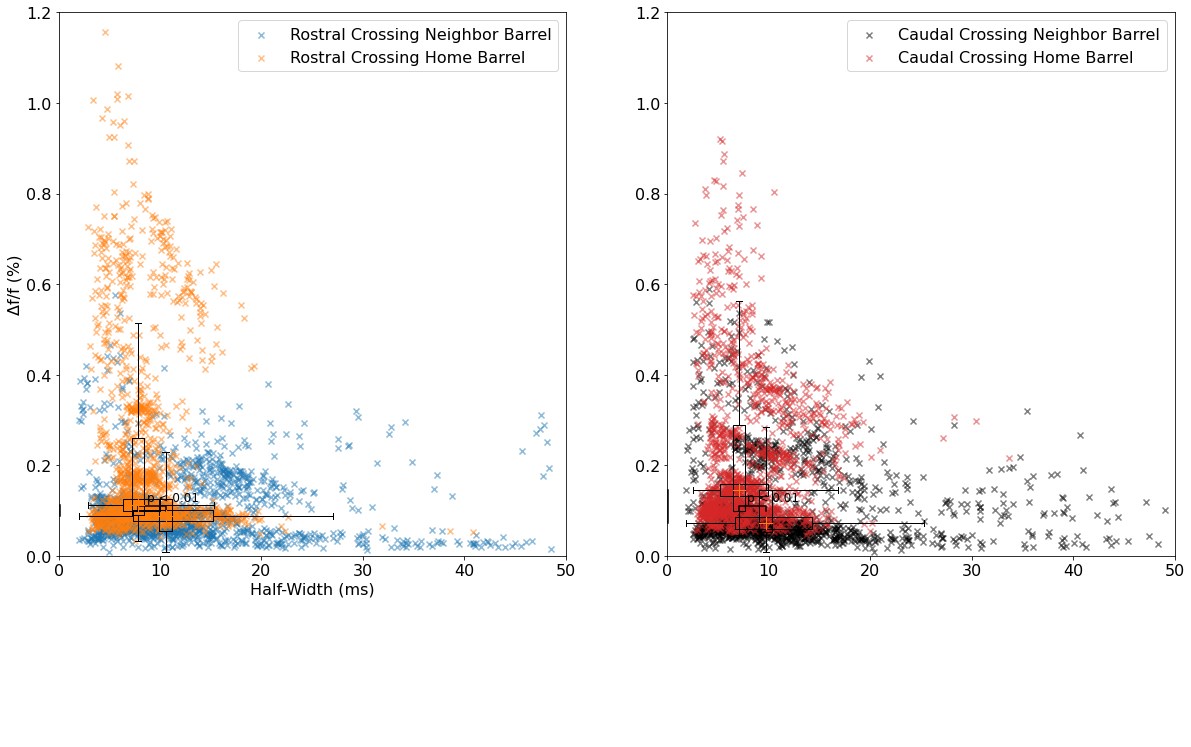

In [97]:
# Is there correlation between amplitude and half-width?
# Make a scatter plot of amplitude vs half-width
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, direction in enumerate(["Rostral", "Caudal"]):
    df = pixel_df[pixel_df['Crossing_Direction'] == direction]
    # split this out by whether Barrel == Home_Barrel or not
    home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
    neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

    l1 = ax[i].scatter( neighbor_barrel_df['Value_hw'], neighbor_barrel_df['Value'] / 10,
                        label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
    l2 = ax[i].scatter(home_barrel_df['Value_hw'], home_barrel_df['Value'] / 10, 
                        label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
    
    # boxplots
    ax[i].boxplot([neighbor_barrel_df['Value'] / 10], positions=[np.median(neighbor_barrel_df['Value_hw'])], 
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value'] / 10], positions=[np.median(home_barrel_df['Value_hw'])],
                    manage_ticks=False, notch=False, widths=1.25, showfliers=False, showbox=True)
    
    # plot horizontal boxplots for halfwidth
    ax[i].boxplot([neighbor_barrel_df['Value_hw']], positions=[np.median(neighbor_barrel_df['Value'] / 10)], 
                    manage_ticks=False, notch=False, widths=0.025, showfliers=False, vert=False, showbox=True)
    ax[i].boxplot([home_barrel_df['Value_hw']], positions=[np.median(home_barrel_df['Value'] / 10)],
                    manage_ticks=False, notch=False, widths=0.025, showfliers=False, vert=False, showbox=True)

    # are there any significant differences between the groups
    # Welch's two-sided t-test
    t_stat, p_val = ttest_ind(neighbor_barrel_df['Value'], home_barrel_df['Value'], alternative='two-sided', equal_var=False)
    print("p_val for amp home vs neighbor:", p_val)
    if p_val < 0.05:
        lx = np.median(home_barrel_df['Value_hw'])
        rx = np.median(neighbor_barrel_df['Value_hw'])
        barx = [lx, lx, rx, rx]
        bary = [0.1, 0.11, 0.11, 0.1]
        ax[i].plot(barx, bary, color='black')
        ax[i].annotate("p < 0.01", (np.mean([lx, rx])-0.5, 0.12), color='black', fontsize=12)

    # are there significant differences in half-width
    t_stat, p_val = ttest_ind(neighbor_barrel_df['Value_hw'], home_barrel_df['Value_hw'], alternative='two-sided', equal_var=False)
    print("p_val for hw home vs neighbor:", p_val)
    if p_val < 0.05:
        lx = np.median(home_barrel_df['Value'] / 10)
        rx = np.median(neighbor_barrel_df['Value'] / 10)
        barx = [lx, lx, rx, rx]
        bary = [0.1, 0.11, 0.11, 0.1]
        ax[i].plot(bary, barx, color='black')
        ax[i].annotate("p < 0.01", (0.12, np.mean([lx, rx])-0.5), color='black', fontsize=12)
ax[0].set_ylabel("Δf/f (%)")
ax[0].set_xlabel("Half-Width (ms)")
ax[0].legend()
ax[1].legend()
for i in range(2):
    ax[i].set_xlim(0, 50)
    ax[i].set_ylim(0, 1.2)
plt.show()

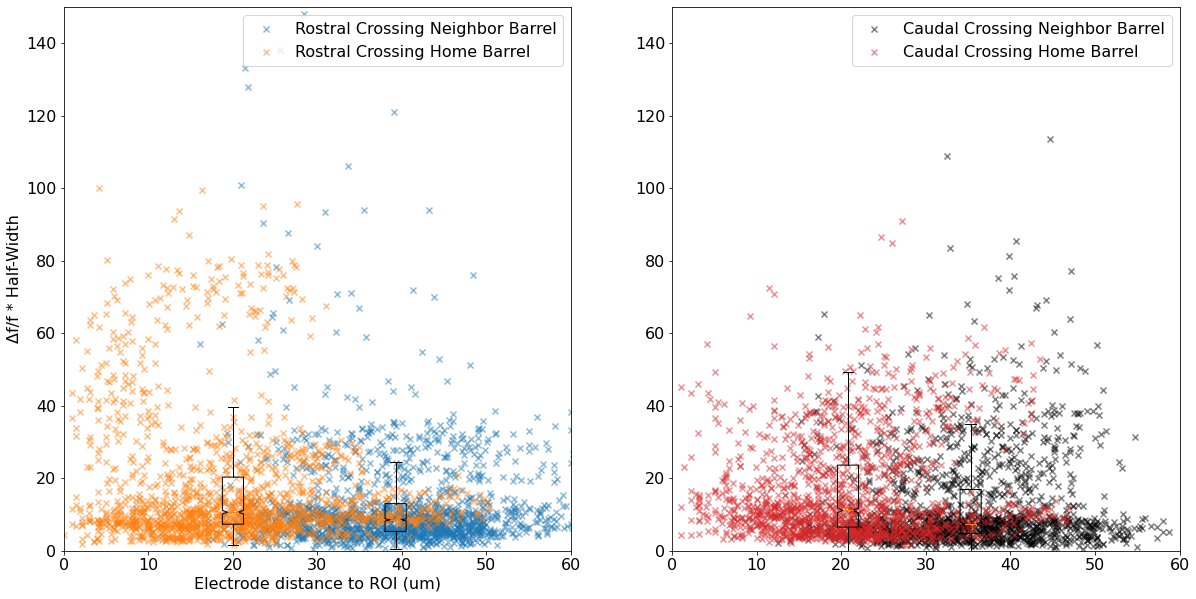

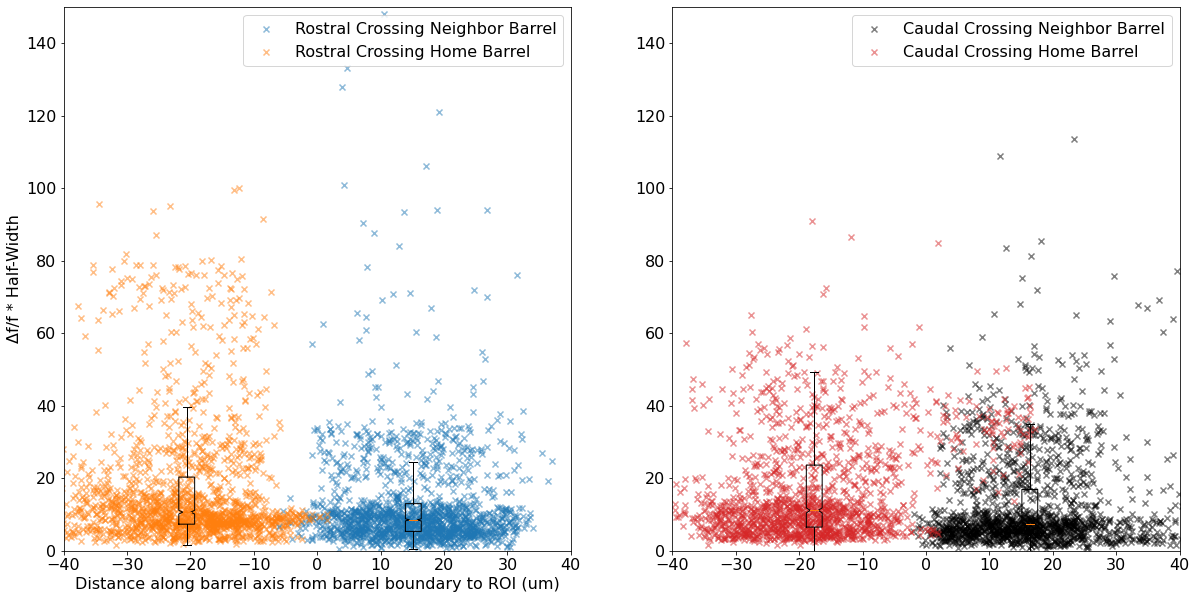

In [63]:
# scatter plot amp * hw versus distance
plt.rcParams.update({'font.size': 16})

for dist_type in ["Distance", "Distance_Along_Barrel_Axis"]:
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for i, direction in enumerate(["Rostral", "Caudal"]):
        df = pixel_df[pixel_df['Crossing_Direction'] == direction]
        # split this out by whether Barrel == Home_Barrel or not
        home_barrel_df = df[df['Barrel'] == df['Home_Barrel']]
        neighbor_barrel_df = df[df['Barrel'] != df['Home_Barrel']]

        l1 = ax[i].scatter( neighbor_barrel_df[dist_type], neighbor_barrel_df['Value'] * neighbor_barrel_df['Value_hw'],
                            label=direction + " Crossing Neighbor Barrel", alpha=0.5, c=colors[i], marker='x')
        l2 = ax[i].scatter(home_barrel_df[dist_type], home_barrel_df['Value'] * home_barrel_df['Value_hw'], 
                            label=direction + " Crossing Home Barrel", alpha=0.5, c=colors[i+2], marker='x')
        
        # boxplots 
        ax[i].boxplot([neighbor_barrel_df['Value'] * neighbor_barrel_df['Value_hw']], positions=[np.mean(neighbor_barrel_df[dist_type])], 
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
        ax[i].boxplot([home_barrel_df['Value'] * home_barrel_df['Value_hw']], positions=[np.mean(home_barrel_df[dist_type])],
                        manage_ticks=False, notch=True, widths=2.5, showfliers=False)
    ax[0].set_ylabel("Δf/f * Half-Width")
    if dist_type == "Distance":
        ax[0].set_xlabel("Electrode distance to ROI (um)")
    elif dist_type == "Distance_Along_Barrel_Axis":
        ax[0].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")        
    ax[0].legend()
    ax[1].legend()
    for i in range(2):
        if dist_type == "Distance":
            ax[i].set_xlim(0, 60)
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[i].set_xlim(-40, 40)
        ax[i].set_ylim(0, 150)
    plt.show()

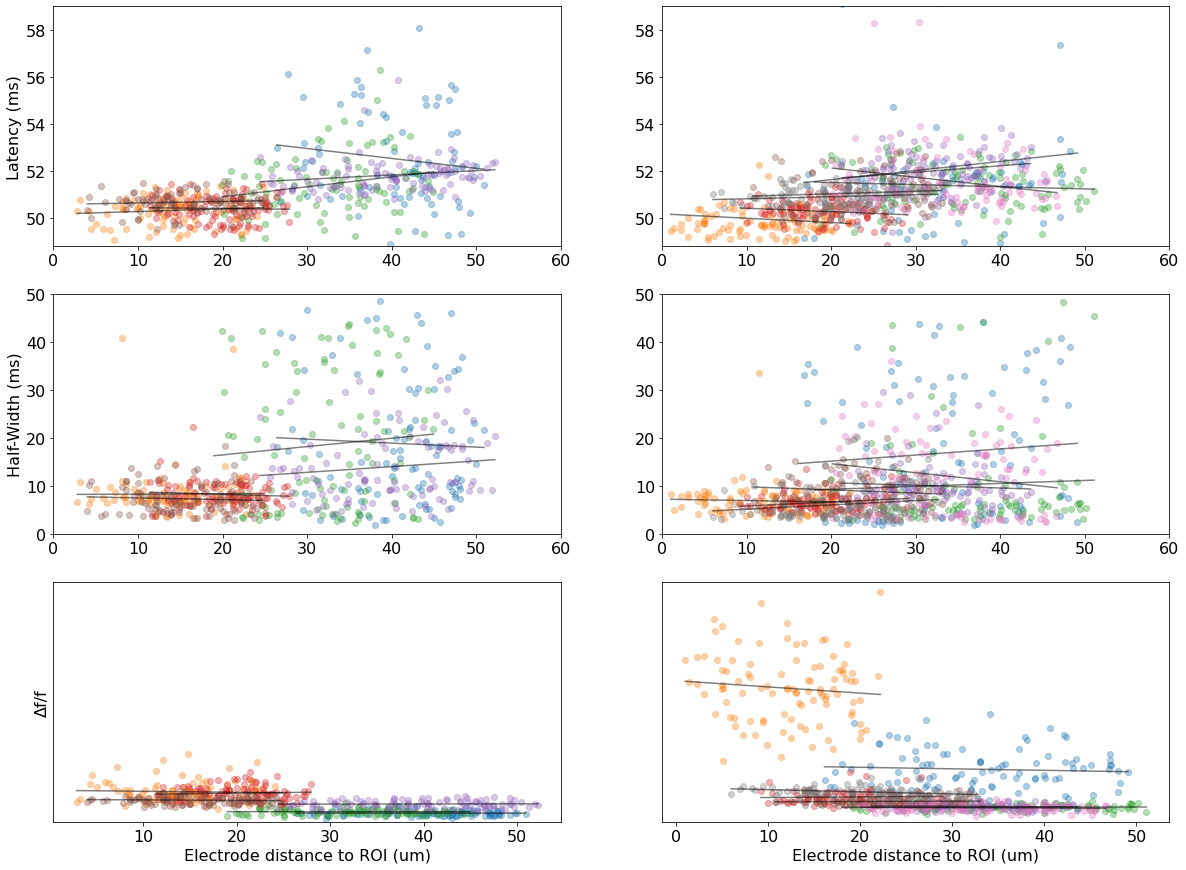

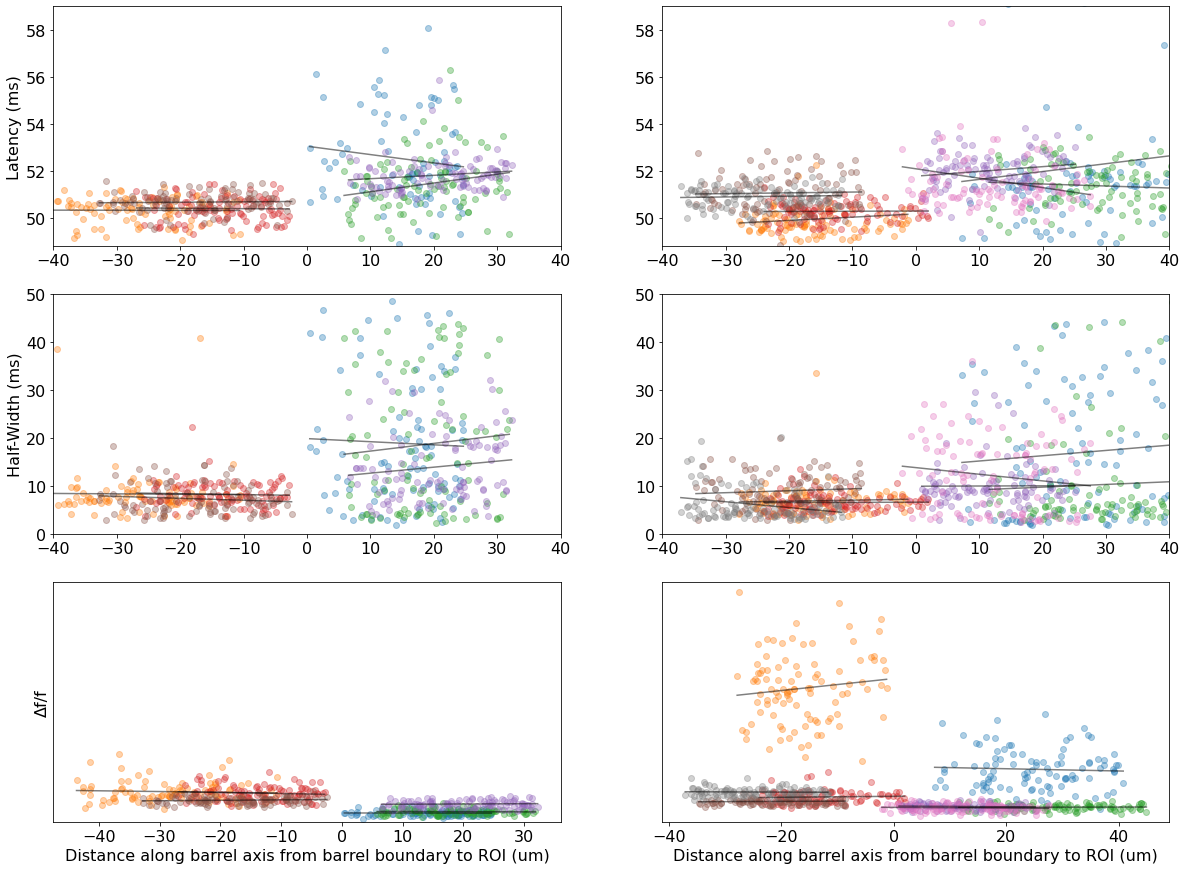

In [165]:
# plot latency vs electrode distance for each crossing direction
# optional amp cutoff
amp_cutoff = None
if amp_cutoff is not None:
    pixel_df = pixel_df[pixel_df['Value'] > amp_cutoff]
plt.rcParams.update({'font.size': 16})
linear_regressions = {}
k = -1
for dist_type in ["Distance", "Distance_Along_Barrel_Axis"]:
    handles = []
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    colors = ['tab:blue', 'black', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',]
    for i, direction in enumerate(["Rostral", "Caudal"]):
        df = pixel_df[pixel_df['Crossing_Direction'] == direction]

        # use a different color for each slice/loc
        for jx, date in enumerate(df['Date'].unique()):
            df_date = df[df['Date'] == date]
            for jxx, slic_loc_id in enumerate(df_date['Slice_Loc'].unique()):
                j = jx + jxx
                df_slic_loc = df_date[(df_date['Slice_Loc'] == slic_loc_id)]

                # split this out by whether Barrel == Home_Barrel or not
                home_barrel_df = df_slic_loc[df_slic_loc['Barrel'] == df_slic_loc['Home_Barrel']]
                neighbor_barrel_df = df_slic_loc[df_slic_loc['Barrel'] != df_slic_loc['Home_Barrel']]

                lat_home = home_barrel_df[(home_barrel_df['Value_lat'] < 1000) & (home_barrel_df['Value_lat'] > 48.8)]
                hw_home = home_barrel_df[(home_barrel_df['Value_hw'] < 1000) & (home_barrel_df['Value_hw'] > 0)]
                lat_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_lat'] < 1000) & (neighbor_barrel_df['Value_lat'] > 48.8)]
                hw_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value_hw'] < 1000) & (neighbor_barrel_df['Value_hw'] > 0)]
                amp_home = home_barrel_df[(home_barrel_df['Value'] < 1000) & (home_barrel_df['Value'] > 0)]
                amp_neighbor = neighbor_barrel_df[(neighbor_barrel_df['Value'] < 1000) & (neighbor_barrel_df['Value'] > 0)]

                alph = 0.35
                l1 = ax[0][i].scatter(lat_neighbor[dist_type], lat_neighbor['Value_lat'], 
                                    label=direction + " Crossing Neighbor Barrel", alpha=alph) #, c=colors[k], marker='x')
                l2 = ax[1][i].scatter(hw_neighbor[dist_type], hw_neighbor['Value_hw'],
                                    label=direction + " Crossing Neighbor Barrel", alpha=alph) #, c=colors[k+1], marker='x')
                l5 = ax[2][i].scatter(amp_neighbor[dist_type], amp_neighbor['Value'],
                                    label=direction + " Crossing Neighbor Barrel", alpha=alph) #, c=colors[k+2], marker='x')
                l3 = ax[0][i].scatter(lat_home[dist_type], lat_home['Value_lat'], 
                                    label=direction + " Crossing Home Barrel", alpha=alph) #, c=colors[k+3], marker='x')
                l4 = ax[1][i].scatter(hw_home[dist_type], hw_home['Value_hw'],
                                    label=direction + " Crossing Home Barrel", alpha=alph) #, c=colors[k+4], marker='x')
                l6 = ax[2][i].scatter(amp_home[dist_type], amp_home['Value'],
                                    label=direction + " Crossing Home Barrel", alpha=alph) #, c=colors[k+5], marker='x')
                
                # fit a linear regression and plot a line for each slice/loc
                for ix, (home, neighbor, value_type) in enumerate([(lat_home, lat_neighbor, 'Value_lat'), 
                                                                   (hw_home, hw_neighbor, 'Value_hw'), 
                                                                   (amp_home, amp_neighbor, 'Value')]):
                    for ixx, df in enumerate([home, neighbor]):
                        if len(df) < 2:
                            continue
                        slope, intercept, r_value, p_value, std_err = linregress(df[dist_type], df[value_type])
                        x = np.linspace(min(df[dist_type]), max(df[dist_type]), 100)
                        y = slope * x + intercept
                        ax[ix][i].plot(x, y, color='black', alpha=0.5)

                # repeat the linear regression fits but with each set centered on its mean
                for ix, (home, neighbor, value_type) in enumerate([(lat_home, lat_neighbor, 'Value_lat'), 
                                                                   (hw_home, hw_neighbor, 'Value_hw'), 
                                                                   (amp_home, amp_neighbor, 'Value')]):
                    for ixx, df in enumerate([home, neighbor]):
                        if len(df) < 2:
                            continue
                        slope, intercept, r_value, p_value, std_err = linregress(df[dist_type] - np.mean(df[dist_type]), df[value_type])
                        x = np.linspace(min(df[dist_type]), max(df[dist_type]), 100)
                        y = slope * (x - np.mean(df[dist_type])) + intercept

                        if dist_type not in linear_regressions:
                            linear_regressions[dist_type] = {}
                        if direction not in linear_regressions[dist_type]:
                            linear_regressions[dist_type][direction] = {}
                        if value_type not in linear_regressions[dist_type][direction]:
                            linear_regressions[dist_type][direction][value_type] = {}
                        if ixx not in linear_regressions[dist_type][direction][value_type]:
                            linear_regressions[dist_type][direction][value_type][ixx] = {}
                        linear_regressions[dist_type][direction][value_type][ixx][slic_loc_id] = [slope, intercept, r_value, p_value, std_err]

    ax[0][0].set_ylabel("Latency (ms)")
    ax[1][0].set_ylabel("Half-Width (ms)")
    ax[2][0].set_ylabel("Δf/f")
    ax[2][0].set_yticks([])
    ax[2][1].set_yticks([])
    for i in range(2):
        if dist_type == "Distance":
            ax[2][i].set_xlabel("Electrode distance to ROI (um)")
        elif dist_type == "Distance_Along_Barrel_Axis":
            ax[2][i].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")

    for i in range(2):
        ax[0][i].set_ylim(48.8, 59)
        ax[1][i].set_ylim(0, 50)
        ax[2][i].set_ylim(0, 0.008)
        for j in range(2):
            if dist_type == "Distance":
                ax[j][i].set_xlim(0, 60)
            elif dist_type == "Distance_Along_Barrel_Axis":
                ax[j][i].set_xlim(-40, 40)
        
    #ax[1][0].legend()
    #ax[1][1].legend()
    plt.show()

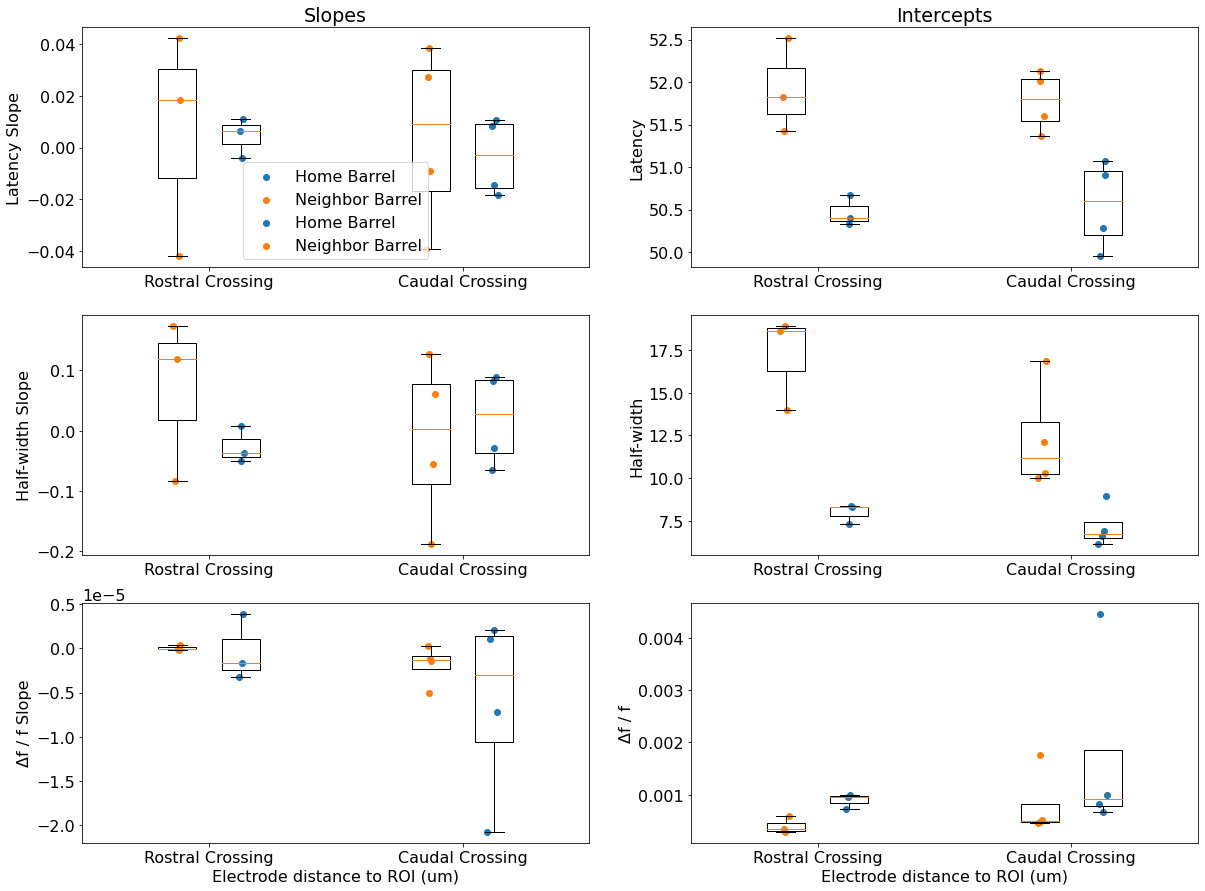

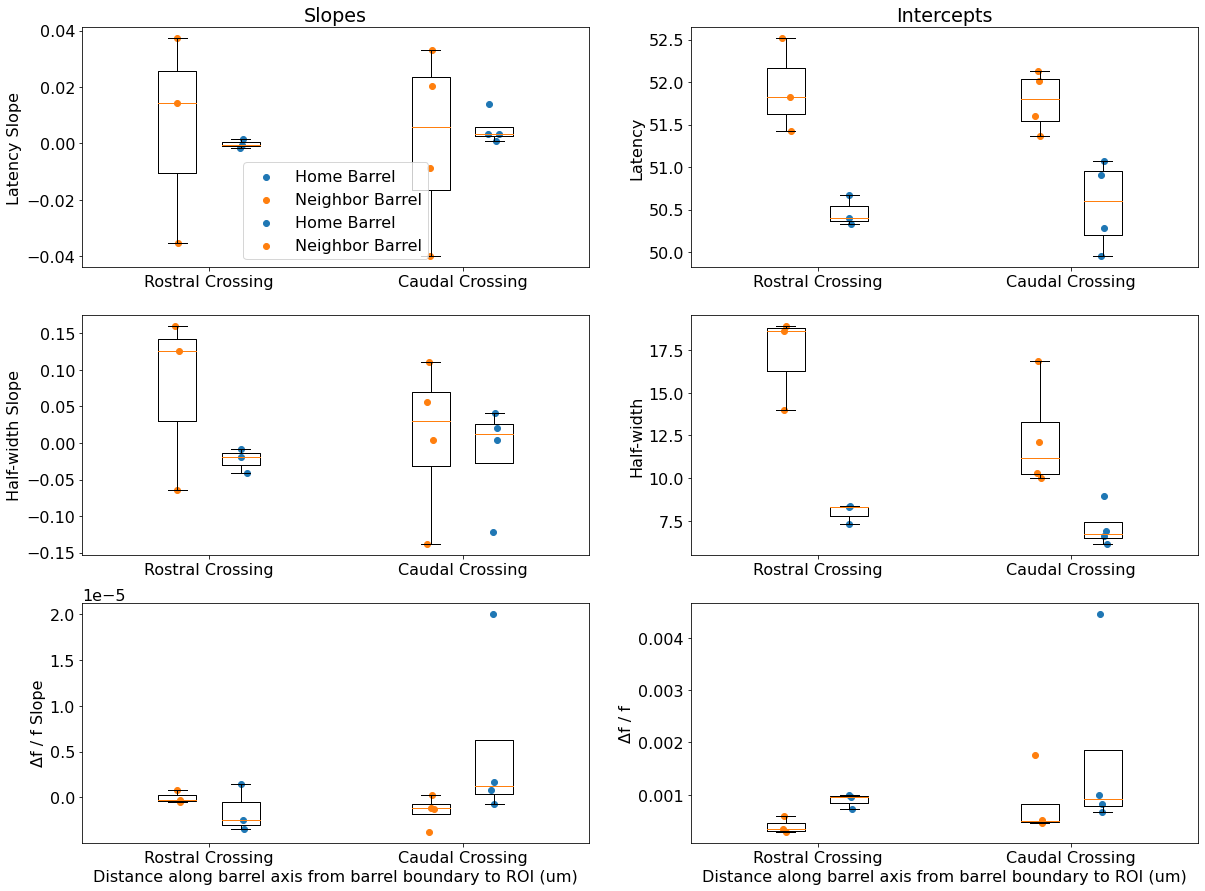

In [193]:
# plot distribution of each slope and intercept for each value type, direction, and distance type
colors = ['tab:blue','tab:orange', 'black', 'tab:green']
handles = []
for dist_type in linear_regressions:
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    for i, direction in enumerate(["Rostral", "Caudal"]):
        for j, (value_type, value_name) in enumerate([['Value_lat', "Latency"], ['Value_hw', 'Half-width'], ['Value', 'Δf / f']]):
            for ixx, home_barrel in enumerate(["Home", "Neighbor"]):

                slopes = []
                intercepts = []
                for slic_loc_id in linear_regressions[dist_type][direction][value_type][ixx]:
                    slopes.append(linear_regressions[dist_type][direction][value_type][ixx][slic_loc_id][0])
                    intercepts.append(linear_regressions[dist_type][direction][value_type][ixx][slic_loc_id][1])
                x_jitter = np.random.normal(0, 0.01, len(slopes)) + i - (ixx * 0.25) + 0.125
                l = ax[j][0].scatter(x_jitter, slopes, label=home_barrel + " Barrel", c=colors[ixx])
                handles.append(l)
                x_jitter = np.random.normal(0, 0.01, len(intercepts)) + i - (ixx * 0.25) + 0.125
                ax[j][1].scatter(x_jitter, intercepts, label=direction, c=colors[ixx])

                # add boxplots
                ax[j][0].boxplot([slopes], positions=[i - (ixx * 0.25) + 0.125], manage_ticks=False, notch=False, widths=0.15, showfliers=False)
                ax[j][1].boxplot([intercepts], positions=[i - (ixx * 0.25) + 0.125], manage_ticks=False, notch=False, widths=0.15, showfliers=False)


                ax[0][0].set_title("Slopes")
                ax[0][1].set_title("Intercepts")
                ax[j][i].set_xlim(-0.5, 1.5)
                ax[j][i].set_xticks([])
                ax[j][i].set_xticks([0, 1])
                ax[j][i].set_xticklabels(["Rostral Crossing", "Caudal Crossing"])
                ax[j][0].set_ylabel(value_name + " Slope")
                ax[j][1].set_ylabel(value_name)
                if dist_type == "Distance":
                    ax[2][i].set_xlabel("Electrode distance to ROI (um)")
                elif dist_type == "Distance_Along_Barrel_Axis":
                    ax[2][i].set_xlabel("Distance along barrel axis from barrel boundary to ROI (um)")


    ax[0][0].legend(handles=[handles[0], handles[-1]], labels=["Home Barrel", "Neighbor Barrel"])
    plt.show()

## 